# Challenge para predecir la presencia de diabetes en los indios Pima

### El objetivo del challenge es medir la capacidad de enfrentar,investigar y resolver un problema utilizando los datos como herramienta


### Información del dataset

* Toda la información que necesitas saber del dataset está en este link: 
*<https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes>*

* Para saber quiénes son los indios Pima: *<https://es.wikipedia.org/wiki/Pueblo_pima>*

### Descripción del problema de negocio

* El departamento de salud de USA le ha asignado la misión de entregar una recomendación de política pública de salud con respecto a la presencia de diabetes en la población de Indios Pima. Para esto, el departamento le ha facilitado el siguiente dataset que contiene 762 observaciones correspondientes a una pre-selección realizada por los investigadores (*<https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/pdf/procascamc00018-0276.pdf>*)


* El objetivo de este trabajo, es hacer una revisión de este estudio y determinar si con las nuevas técnicas y herramientas disponibles en la actualidad es posible entregar mejores recomendaciones o si se deben mantener las recomendaciones entregadas previamente


### Estructura con la cual debe responder el desafio

* Descripción de la estrategia de solución: Debe explicar cuál es la estrategia de solución que seguirá y luego argumentar por qué la escogió


* Implementación: En esta fase debe especificar y comentar todo lo relativo a la implimentación de esa estrategia de solución, siendo bien claro en la metodología que siguió y los resultados obtenidos


* Discusión de resultados: En esta fase debe discutir los resultados obtenidos en la fase anterior, especificando las fortalezas y posibles debilidades de los mismos, y proponer posibles caminos de mejoras para el futuro


* Recomendaciones: Finalmente, debe contestar al departamento salud presentando los resultados de la forma que usted estime conveniente y siendo muy claro y específico en las recomendaciones que entrega a partir de ellos.

### Lenguajes que puede utilizar en la implementación de su estrategia

* Python
* R

### Librerias recomendables

   - [Pandas](https://pandas.pydata.org/) 
   - [Scikit Learn](http://scikit-learn.org/) 
   - [Numpy](http://www.numpy.org/) 
   - [imbalanced-learn ](https://github.com/scikit-learn-contrib/imbalanced-learn)
   - [matplotlib ](https://matplotlib.org)

### Entregables

* Un notebook de jupyter con todo el código del procesamiento de los datos y los resultados de la predicción en formato PDF

* Un documento escrito en formato pdf o word:
    * La descripción de la estrategia de soluciones
    * La discusión de resultados 
    * Recomendaciones
    
    
** Se recomienda utilizar Jupyther Notebook para realizar ambos entregables, sin embargo solo es obligación entregar los resultados del procesamiento y predicción en un jupyter notebook convertido a PDF **

** Para instalar Jupyter Notebook *<http://jupyter.org/install>* **

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import matplotlib as mpl
from time import time
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import LinearSVC,SVC
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

### Creación de funciones

* La función plot_pie fué extraída de un notebook en Kaggle (sin referencia por el momento)


* El resto de las funciones fueron creadas por mi para simplificarme algunas tareas repetitivas y/o que la función entregue la interpretación del test directamente

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')
    
def get_hist(var1,var2,values_range=[0,1],nbins=20,normed=True,name_image='2hist.png'):
    
    common_params = dict(bins=nbins,range=values_range,normed=normed)
    plt.subplots_adjust(hspace=.8)
    plt.subplot(311)
    plt.title('Default')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)
    plt.subplot(312)
    plt.title('Skinny shift - 2 at a time')
    plt.hist((var1, var2), **common_params)
    plt.subplot(313)
    common_params['histtype'] = 'step'
    plt.title('With steps')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)

    plt.savefig(name_image)
    plt.show()

def expected_values(var1,var2):
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    return expected

def chi2_test(var1,var2,alpha=0.99):
    #Creamos la tabla de contingencia con los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    #Creamos la tabla de valores esperados
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    #Creamos la tabla de contingencia sin los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2)
    #calculamos el valor calculado de chi2
    chi_squared_stat = (((contingencyTable-expected)**2)/expected).sum().sum()
    #calculamos los grados de libertad
    dof=(len(contingencyTable.columns)-1)*(len(contingencyTable.index)-1)
    #calculamos el valor crítico de chi2
    crit = sp.stats.chi2.ppf(q = alpha,df = dof)
    #calulamos el p-valor
    p_value = 1 - sp.stats.chi2.cdf(x=chi_squared_stat,df=dof)
    #testeamos la hipótesis nula de independencia entre las variables
    if(chi_squared_stat<=crit):
        print('no hay evidencia suficiente para rechazar H0, los valores son independientes y el p-valor es: {}'
              '\n el p-valor es:'.format(round(p_value,4)))
        #print("los valores esperados son: "+ str(expected))
    else:
        print('Se rechaza H0, no hay evidencia para decir que los valores son independientes'
              '\n y el p-valor es: {}'.format(round(p_value,4)))
        #print("los valores esperados son: "+ str(expected))

def bivariant_boxplot(df,column_name,target):
    print(df.groupby(target)[column_name].describe())
    bp = df.boxplot(column=column_name,by=target,grid=False)
    for i in [0,1]:
        y = df[column_name][df.Outcome==i].dropna()
        x = np.random.normal(i, 0.02, size=len(y))
        plt.plot(x, y, 'rs', alpha=0.1)

In [3]:
def variable_selection(X,y):
    
    # Generamos la métrica de mutual information de los features con respecto al Score 
    mi = mutual_info_classif(X,y,random_state=0,discrete_features='auto')
    # Creamos el dataframe con los resultados
    raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
    features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
    features_mi=features_mi.sort_values(by='m-weight',ascending=False)
    
    # Generamos el el clasificador con Random Forest
    clf = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=23,
        n_estimators=300,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =23)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Random Forest
    rfe_rf = RFE(clf, n_features_to_select=1)
    fit_rf = rfe_rf.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
    features_ffe_rf=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
    selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                               sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Regresión logística
    model = LogisticRegression(random_state=0,warm_start=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Regresión Logística
    rfe_lr = RFE(model, n_features_to_select=1)
    fit_rl = rfe_lr.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
    features_ffe_rl=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                               sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                               indicator=False)
    
    # Generamos el el clasificador con Gradient Boosting
    model = GradientBoostingClassifier(
        random_state=0,max_features='sqrt',subsample=0.8,
        n_estimators=300,min_samples_split = 20,warm_start=True,presort=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Gradient Boosting
    rfe_gb = RFE(model, n_features_to_select=1)
    fit_gb = rfe_gb.fit(X=X, y=y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
    features_ffe_gb=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                               suffixes=('', '_ffe_gb'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Linear SVC
    lsvc = LinearSVC(C=1, penalty="l1", random_state=0,dual=False,loss='squared_hinge').fit(X, y)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Linear SVC
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
    features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
    features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
    selected_features=pd.merge(left=selected_features,right=features_svc, how='left', on='features',
                               sort=False,suffixes=('', '_svc_lineal'), copy=True, indicator=False)
    
    return selected_features

### Extracción y comprensión de la data

* El fragmento siguiente carga el conjunto de datos de inicio de diabetes de los indios Pima

* Link a los datos *<https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes>*

In [4]:
url = "diabetes.csv"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'clas']
df = pd.read_csv(url)
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


1. Pregnancies: Number of times pregnant
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test 3. Diastolic blood pressure (mm Hg)
3. BloodPressure: sistolic presion
4. SkinThinkness: Triceps skin fold thickness (mm)
5. Insulin: 2-Hour serum insulin (mu U/ml)
6. BMI: Body mass index (weight in kg/(height in m)ˆ2)
7. DiabetesPedigreeFunction: Diabetes pedigree function
8. Age:  Age (years)
9. Outcome: Class variable (0 or 1)

### EDA

* Se realiza el análisis estadístico básico de los datos para comprender la distribución y estructura de los datos


* En los histogramas podemos ver que la distribución de las variables de edad, función de pedigree, espesor de la piel y embarazos distribuyen de forma similar, con un gran sesgo hacia la izquierda. Las variables BMI, Glucosa y presión sanguinea siguen una distribución más parecida a la normal, con la media cercana a la mediana y una concentración importante de los valores en el 75% central de los datos. 


* Sin embargo,cuando vemos las medidas de tendencia central, inmediatamente notamos una anomalía: la existencia de valores 0 en variables donde no es posible que existan, como por ejemplo: presión sanguinea, concentración de glucosa, nivel de insulina en la sangre, etc. Dado que se desconoce el origen de este error, se tomarán estos valores como NA's y por lo tanto se genera la conversión para luego volver a revisar los datos

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

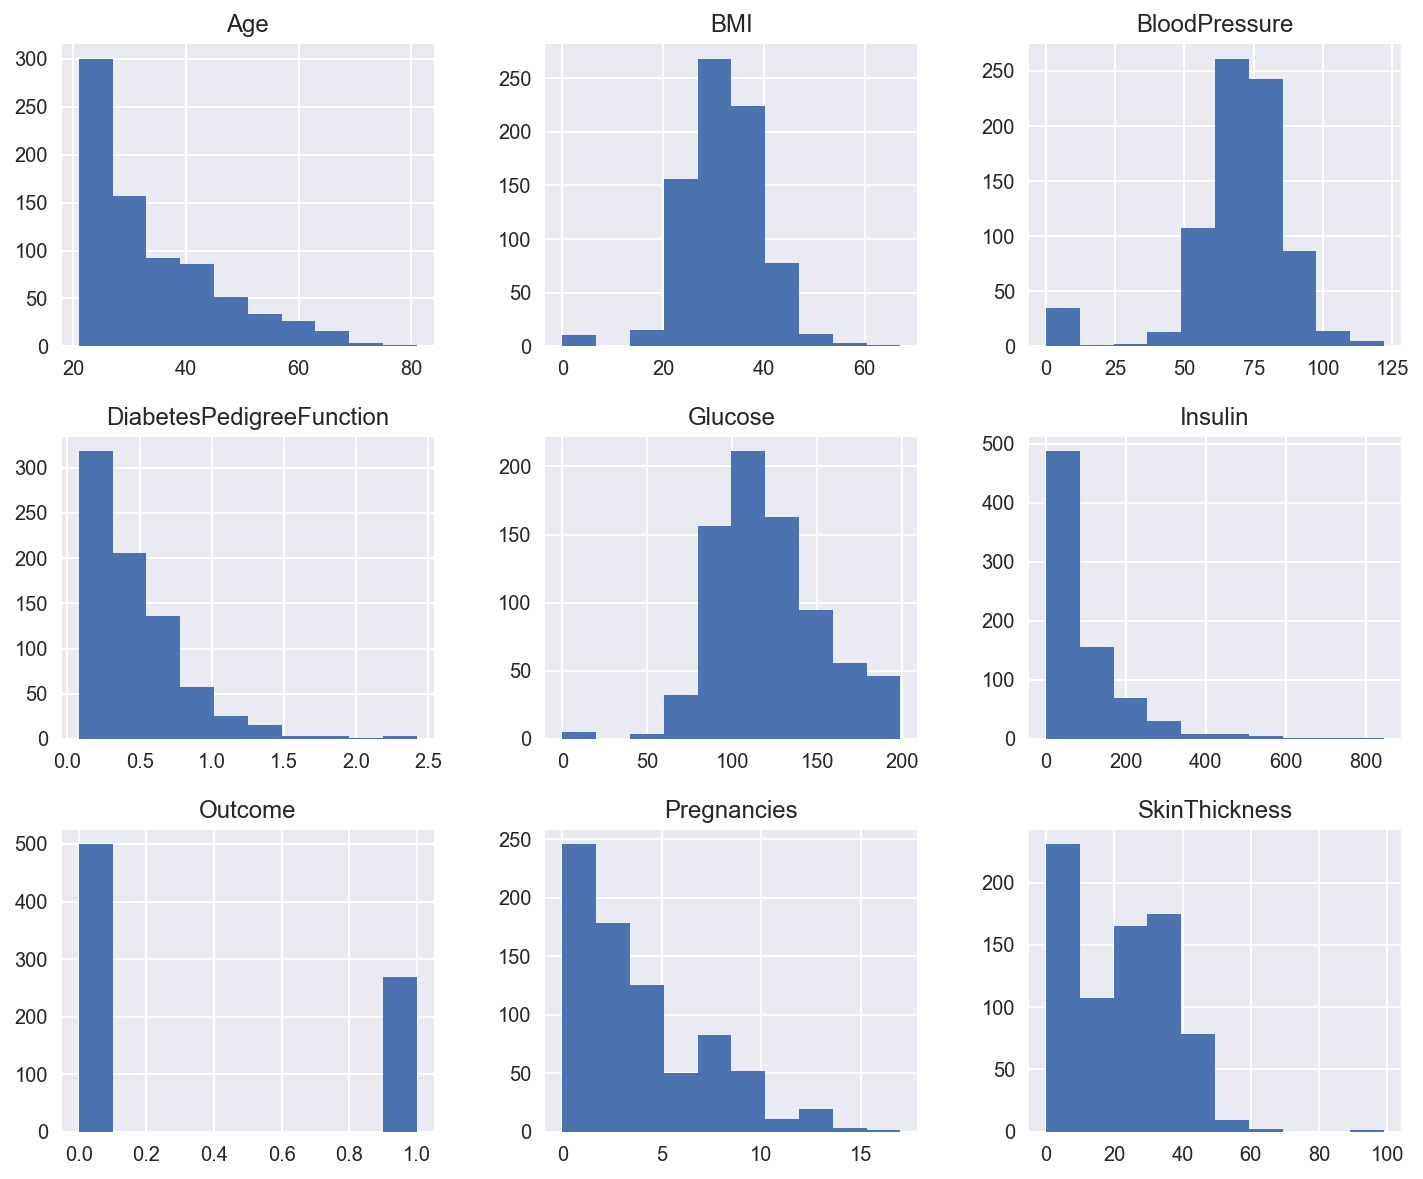

In [5]:
print(df.describe())
df.hist(figsize=(12,10));

In [6]:
df['Glucose'] = df['Glucose'].replace(0, np.nan)
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

* Observamos que la mayor cantidad de NA's están en las variables que entregan los valores de concentración de insulina y espesor de la piel. Antes de decidir cómo se resolverá este problema, vamos a comprender la relación de las variables entre ellas y con la presencia de diabetes 


* La presión sanguinea, BMI y glucosa presentan menos de un 5% de valores NA's, sin embargo dado lo pequeña de la muestra, intentaremos minimizar al máximo la eliminación de datos 

In [7]:
qna=df.shape[0]-df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qna, 'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,Na en %,datos sin NAs en q
Insulin,48.70,394
SkinThickness,29.56,541
BloodPressure,4.56,733
BMI,1.43,757
Glucose,0.65,763
Pregnancies,0.00,768
DiabetesPedigreeFunction,0.00,768
Age,0.00,768
Outcome,0.00,768


In [8]:
X=df.dropna().loc[:, df.columns != 'Outcome']
y=df.dropna().Outcome.values.ravel()

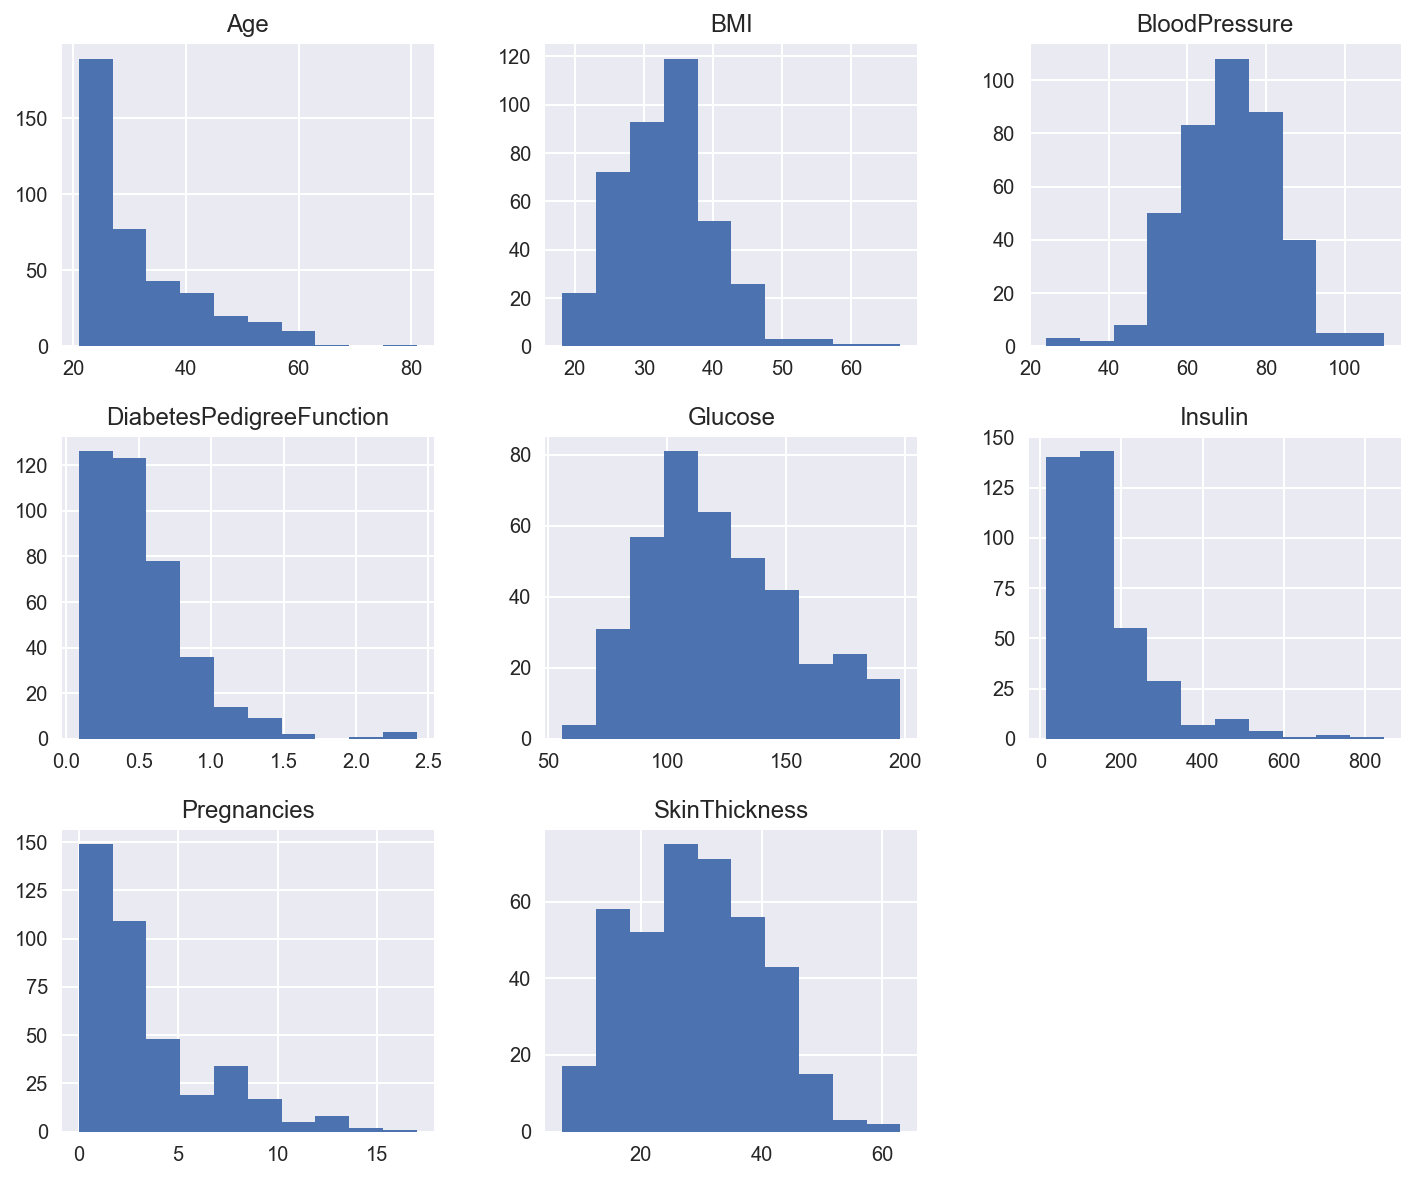

In [9]:
X.hist(figsize=(12,10));

In [10]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000


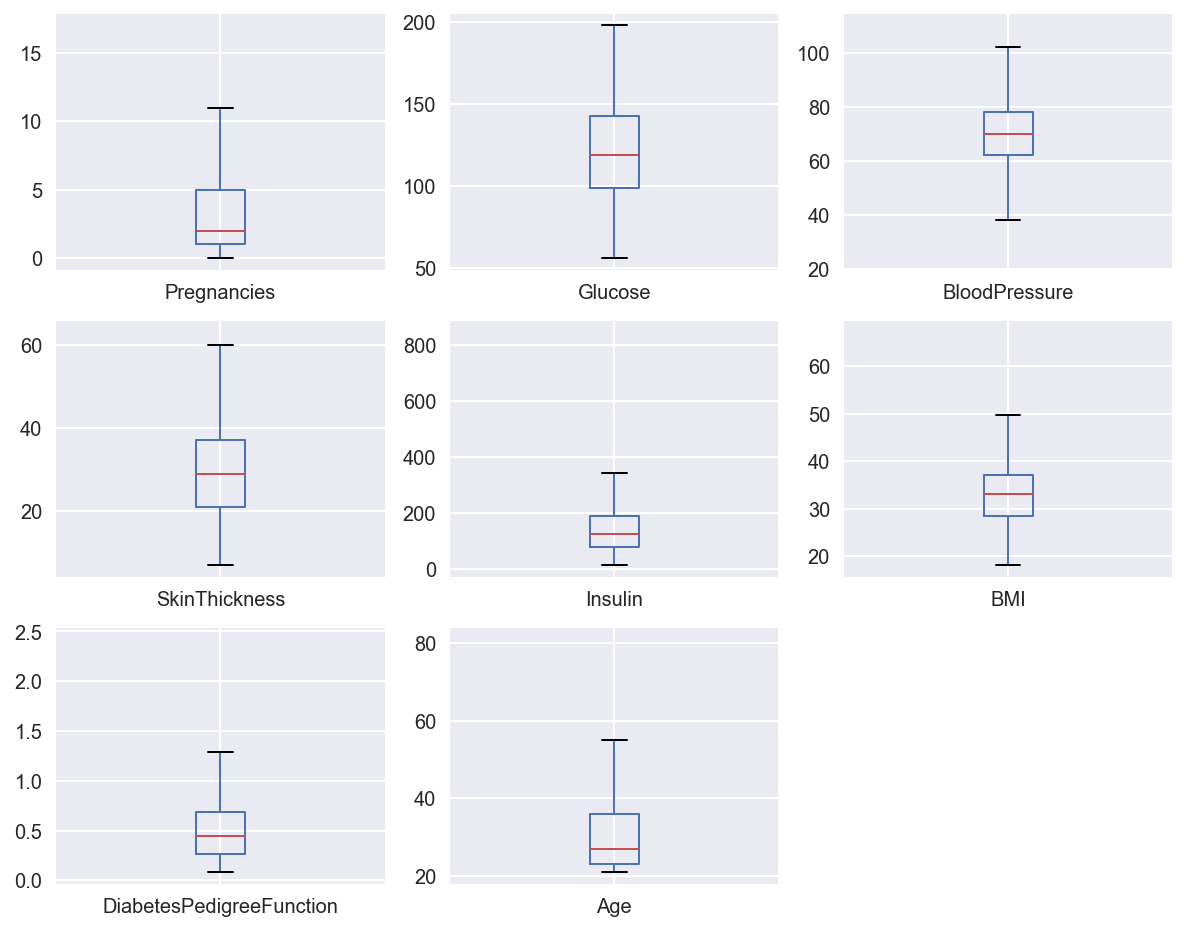

In [11]:
X.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,8));

In [12]:
corr = X[X.columns].corr()
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.198291,0.213355,0.093209,0.078984,-0.025347,0.007562,0.679608
Glucose,0.198291,1.000000,0.210027,0.198856,0.581223,0.209516,0.140180,0.343641
BloodPressure,0.213355,0.210027,1.000000,0.232571,0.098512,0.304403,-0.015971,0.300039
SkinThickness,0.093209,0.198856,0.232571,1.000000,0.182199,0.664355,0.160499,0.167761
Insulin,0.078984,0.581223,0.098512,0.182199,1.000000,0.226397,0.135906,0.217082
BMI,-0.025347,0.209516,0.304403,0.664355,0.226397,1.000000,0.158771,0.069814
DiabetesPedigreeFunction,0.007562,0.140180,-0.015971,0.160499,0.135906,0.158771,1.000000,0.085029
Age,0.679608,0.343641,0.300039,0.167761,0.217082,0.069814,0.085029,1.000000


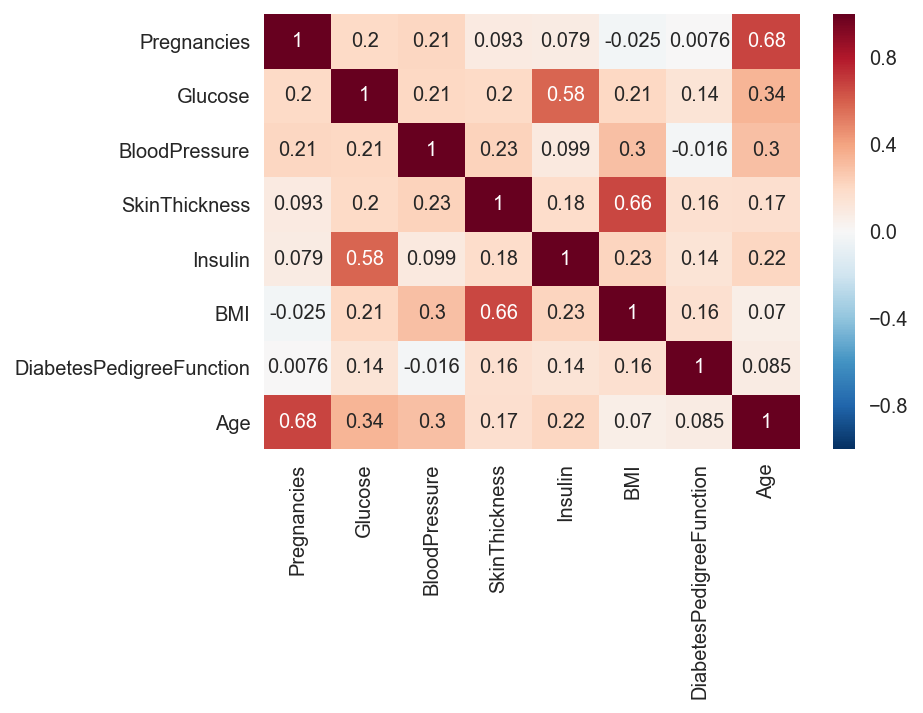

In [13]:
sns.heatmap(corr, annot = True);

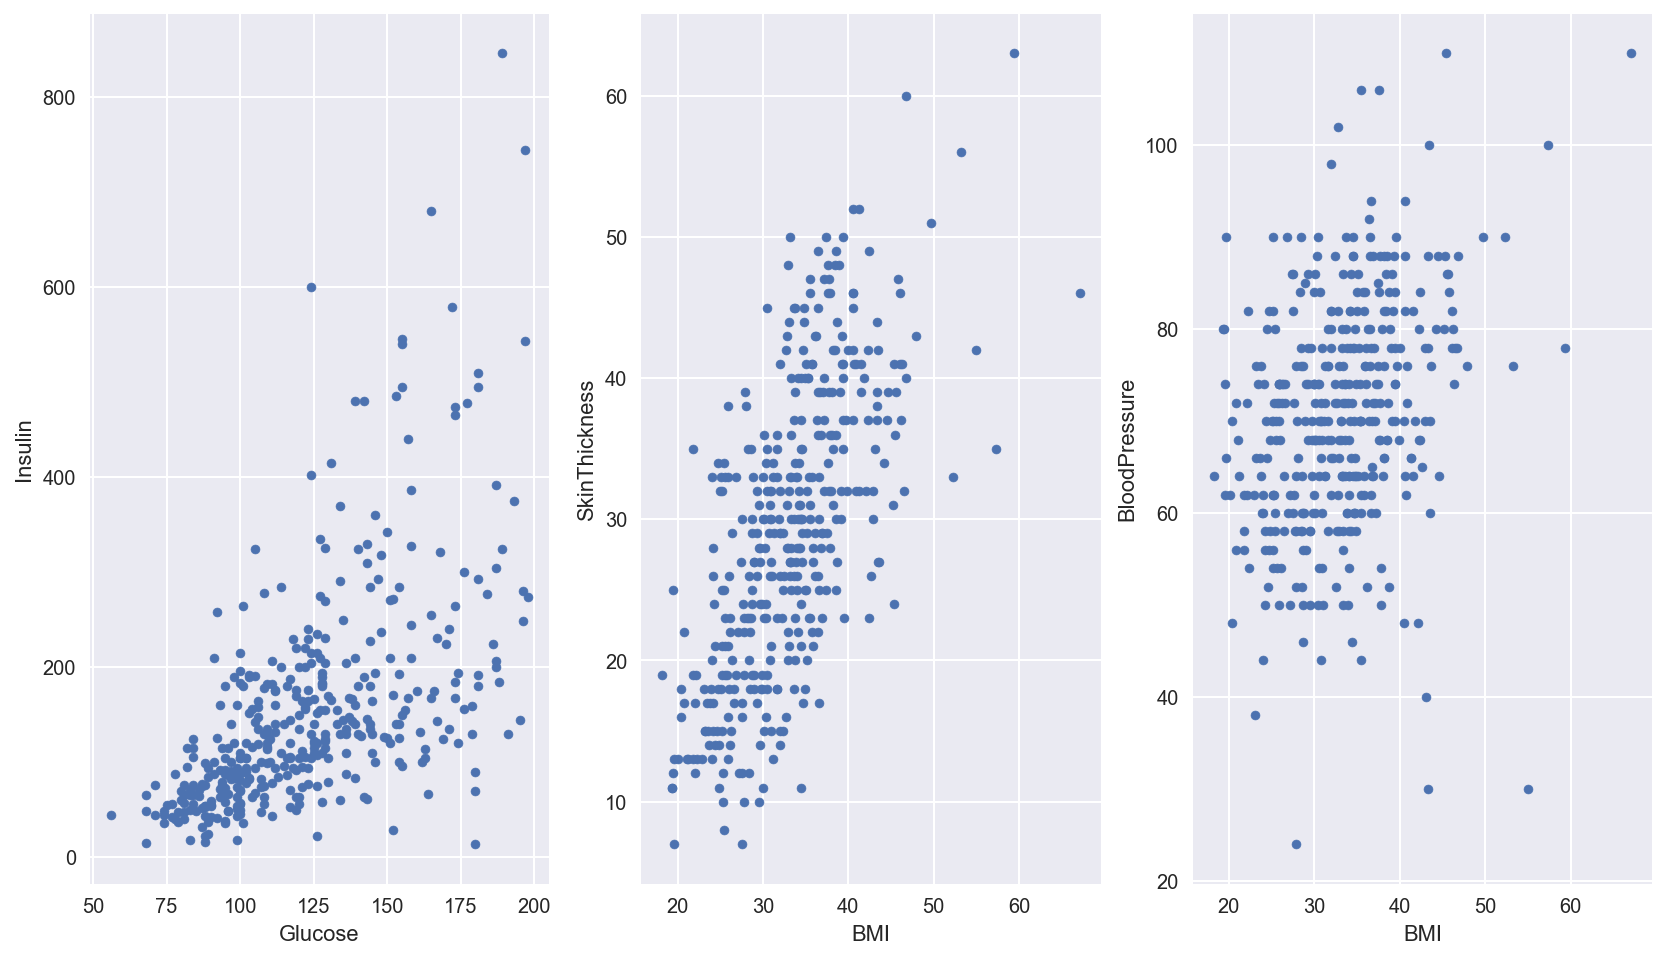

In [14]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=False)
X.plot(kind='scatter', x='Glucose', y='Insulin', ax=axs[0], figsize=(14, 8))
X.plot(kind='scatter', x='BMI', y='SkinThickness', ax=axs[1],figsize=(14, 8))
X.plot(kind='scatter', x='BMI', y='BloodPressure', ax=axs[2],figsize=(14, 8));

In [15]:
selected_features=variable_selection(X=X,y=y)
selected_features

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
0,Glucose,0.157667,1.000000,1,3,1,0.013819,4
1,Age,0.085264,0.540787,2,7,5,0.012091,5
2,Insulin,0.070790,0.448982,3,8,4,0.000322,8
3,BMI,0.057719,0.366083,4,6,2,0.022799,3
4,Pregnancies,0.035784,0.226960,5,2,8,0.028509,2
5,SkinThickness,0.030135,0.191132,6,4,7,0.003483,6
6,BloodPressure,0.007648,0.048505,8,5,6,0.000929,7
7,DiabetesPedigreeFunction,0.000000,0.000000,7,1,3,0.348530,1


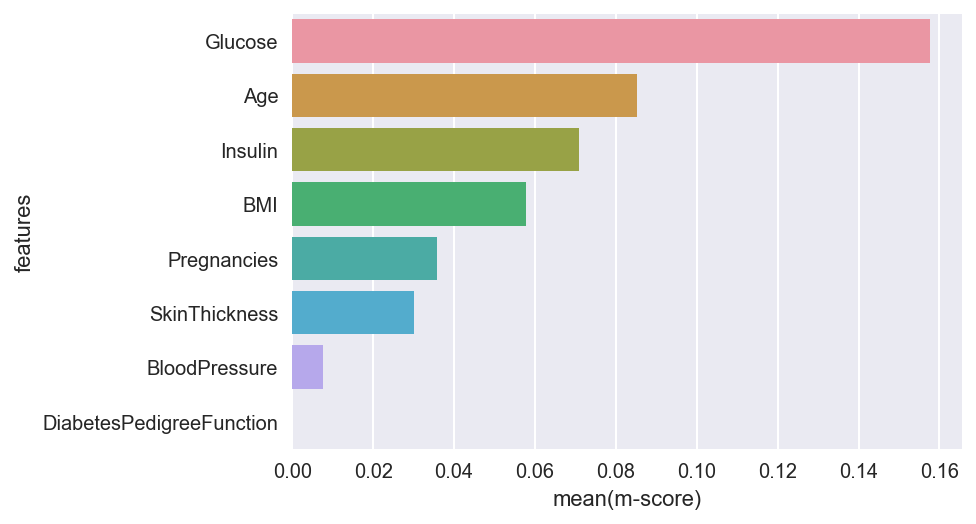

In [16]:
sns.barplot(x='m-score', y='features', data=selected_features);

### Eliminación de variables

* Se eliminan las variables de insulina y espesor de la piel ya que presentan una alta proporción de valores NAs y están fuertemente correlacionadas con las variables de Glucosa y BMI, como se puede observar en los gráficos que se mostraron arriba



* Dado que la variable BloodPressure tiene 35(5%) NAs y es la variable con menor relevancia/impacto (medida por mutual information y por importancia de las variables según RFE y Random Forest) para explicar la presencia de diabetes, se decide eliminar la presión sistólica como variable

In [17]:
del df['Insulin']
del df['SkinThickness']

In [18]:
X=df.dropna().loc[:, df.columns != 'Outcome']
y=df.dropna().Outcome.values.ravel()

In [19]:
selected_features=variable_selection(X=X,y=y)
selected_features

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
0,Glucose,0.117101,1.000000,1,4,3,0.013073,4
1,BMI,0.064057,0.547025,2,3,2,0.031475,3
2,Age,0.053545,0.457251,3,6,4,0.005630,5
3,Pregnancies,0.027248,0.232691,5,2,6,0.042830,2
4,DiabetesPedigreeFunction,0.016365,0.139748,4,1,1,0.305947,1
5,BloodPressure,0.015515,0.132491,6,5,5,0.003208,6


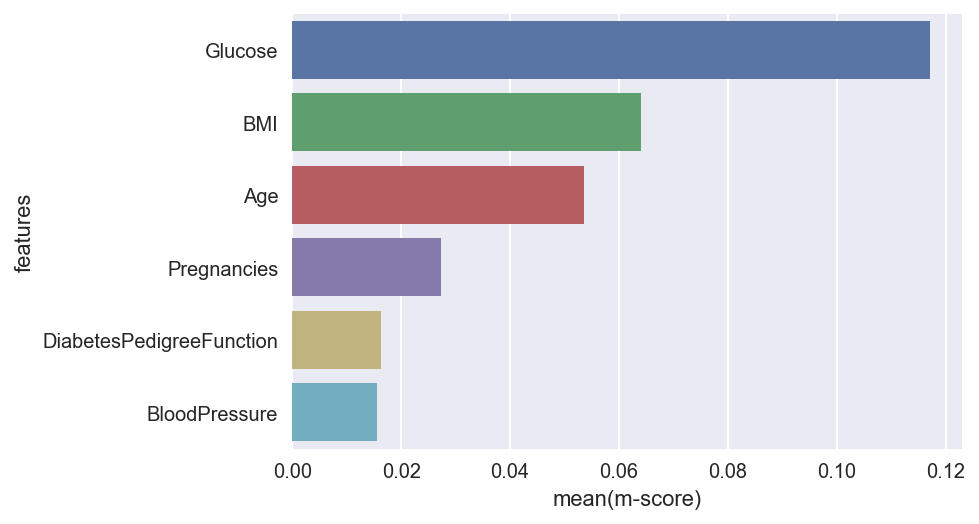

In [20]:
sns.barplot(x='m-score', y='features', data=selected_features);

         count       mean        std   min   25%   50%   75%    max
Outcome                                                            
0        481.0  70.877339  12.161223  24.0  62.0  70.0  78.0  122.0
1        252.0  75.321429  12.299866  30.0  68.0  74.5  84.0  114.0


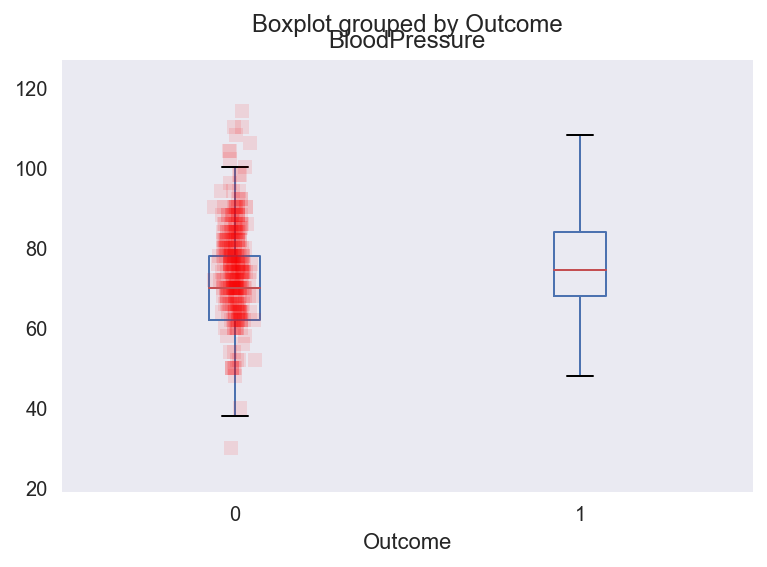

In [21]:
bivariant_boxplot(df=df,column_name='BloodPressure',target='Outcome')

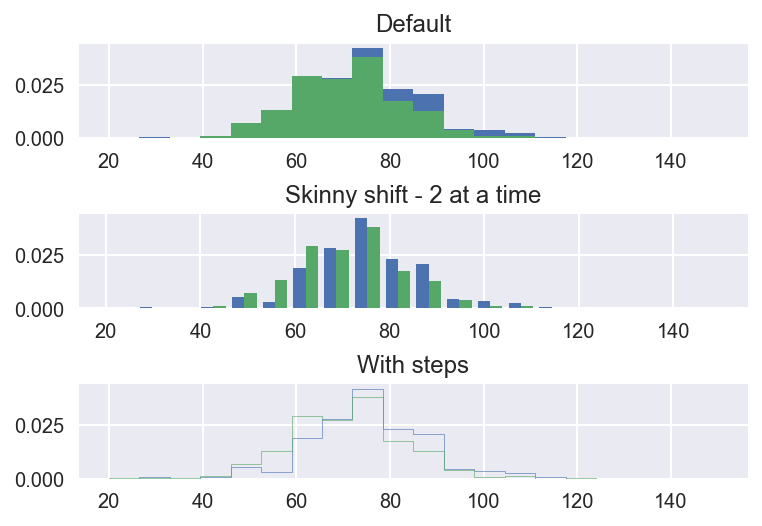

In [22]:
get_hist(df[df.Outcome==1].BloodPressure,df[df.Outcome==0].BloodPressure,
         values_range=[20,150],nbins=20,normed=True,name_image='2hist_BloodPressure.png');

In [23]:
del df['BloodPressure']

### EDA con los datos finales

* Una vez realizadas las eliminaciones de variables se procede a eliminar los 6 registros que continen NA's de la variable BMI


* Posteriormente se termina el análisis estadístico de cada variable por si sola y su relación e impacto en la presencia de diabetes 

Información del dataset:
 las clases del target son: Counter({0: 488, 1: 264})


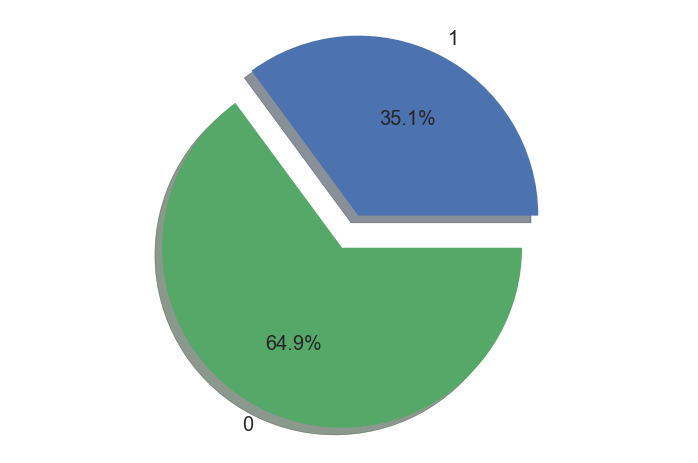

In [24]:
df=df.dropna().copy()
X=df.loc[:, df.columns != 'Outcome']
Y=df.Outcome.values.ravel()
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(Y)))
plot_pie(Y)

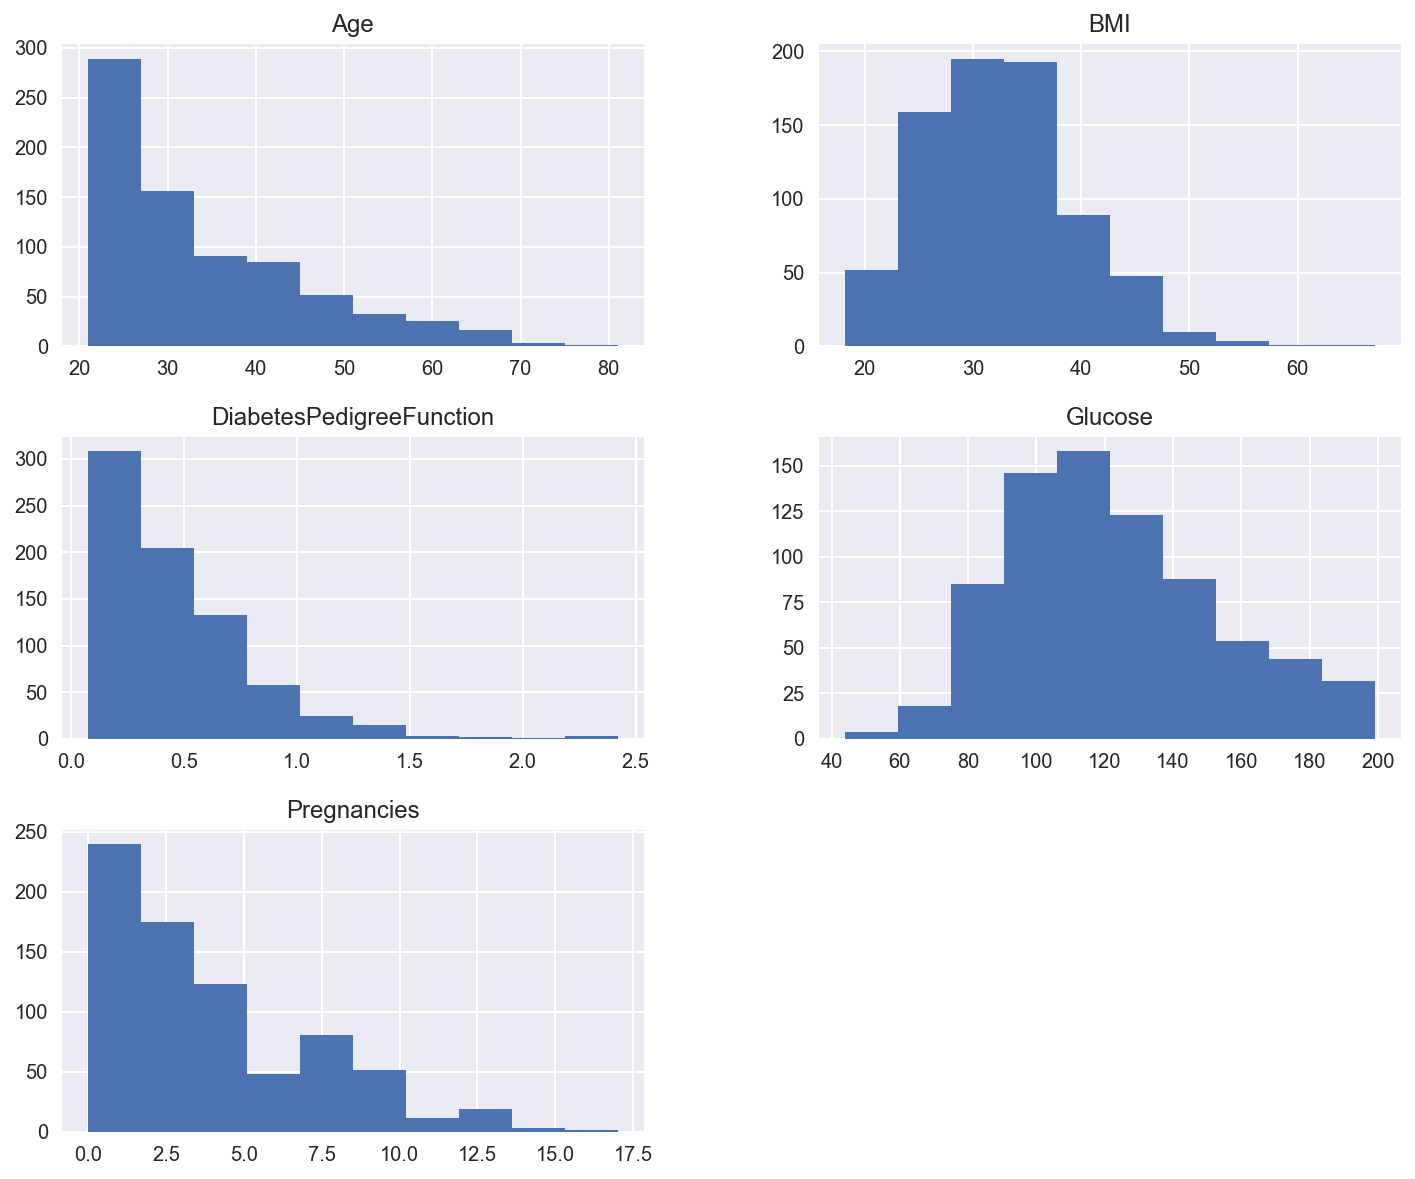

In [25]:
X.hist(figsize=(12,10));

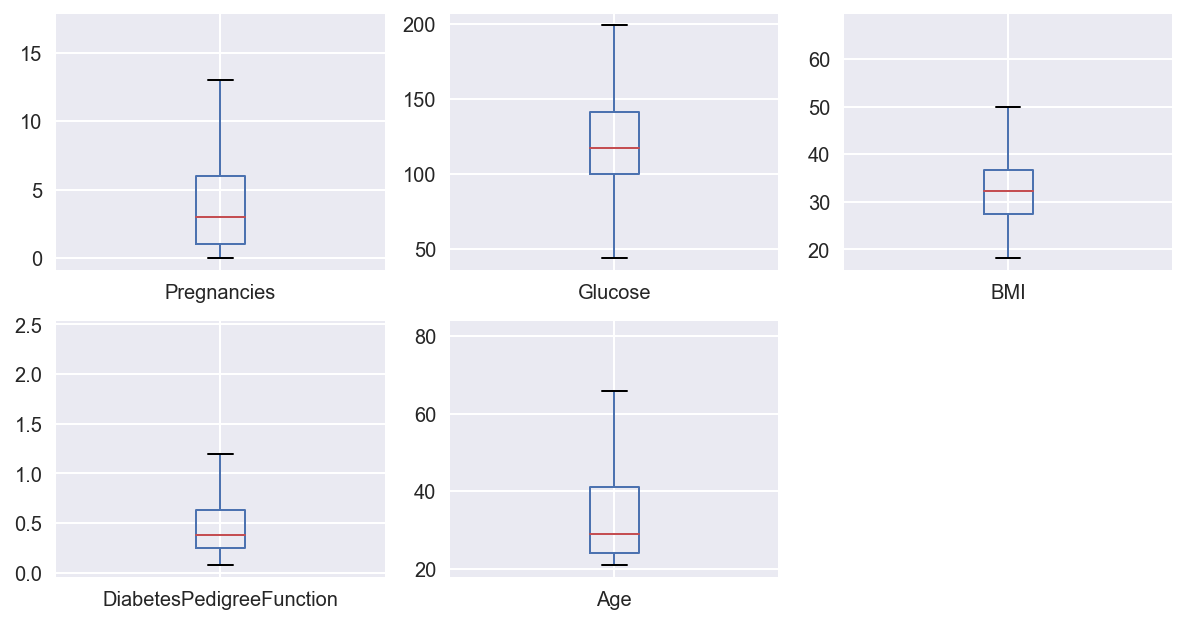

In [26]:
X.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,8));

         count      mean       std    min      25%     50%      75%    max
Outcome                                                                   
0        488.0  0.429848  0.295357  0.078  0.23075  0.3375  0.56175  2.329
1        264.0  0.552909  0.373857  0.088  0.26375  0.4515  0.73125  2.420


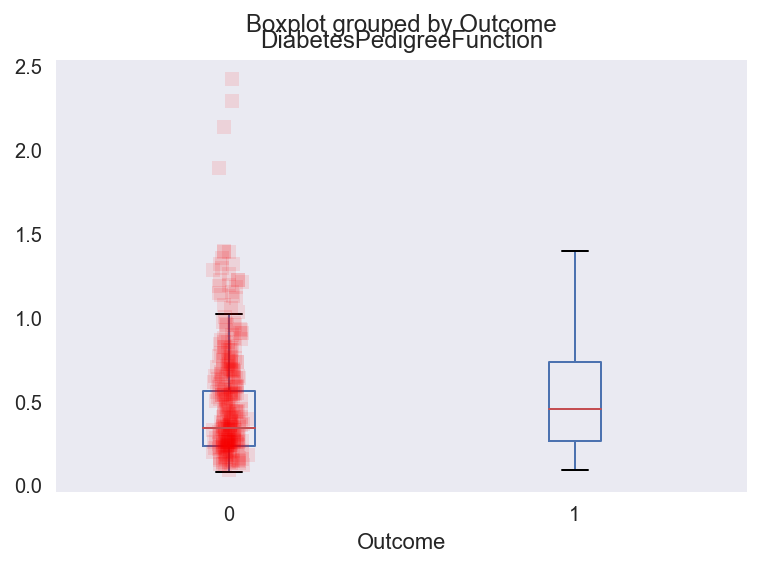

In [27]:
bivariant_boxplot(df=df,column_name='DiabetesPedigreeFunction',target='Outcome')

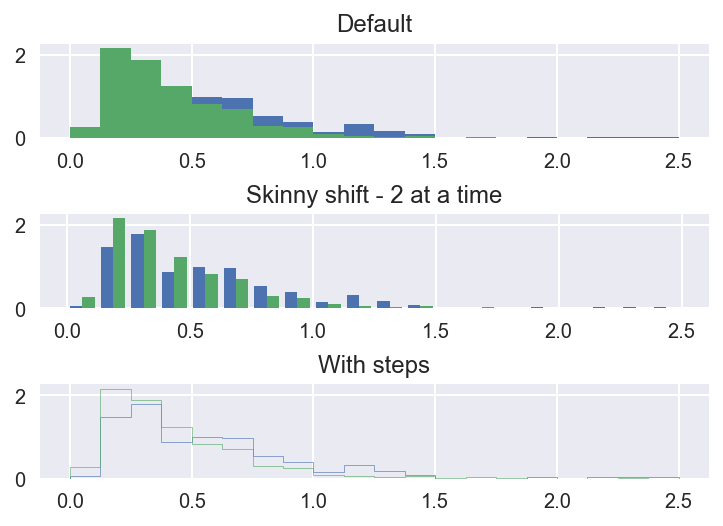

In [28]:
get_hist(df[df.Outcome==1].DiabetesPedigreeFunction,df[df.Outcome==0].DiabetesPedigreeFunction,
         values_range=[0,2.5],nbins=20,normed=True,name_image='2hist_DiabetesPedigreeFunction.png');

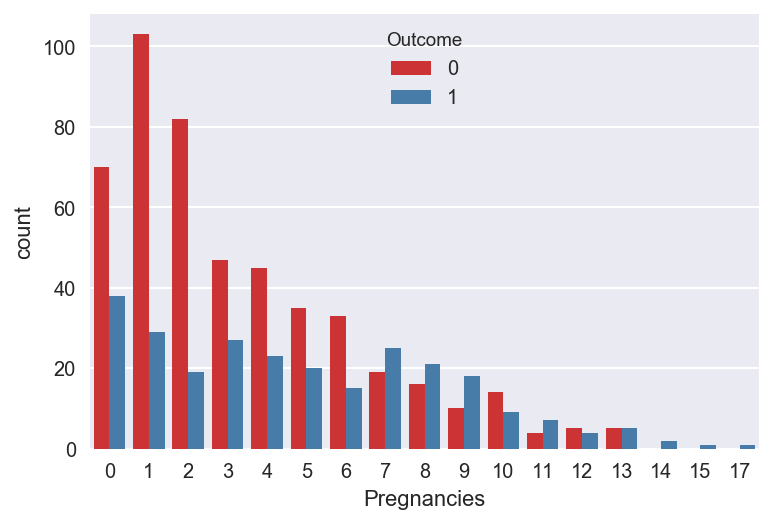

In [29]:
sns.countplot(x='Pregnancies', hue='Outcome', data=df, palette='Set1');

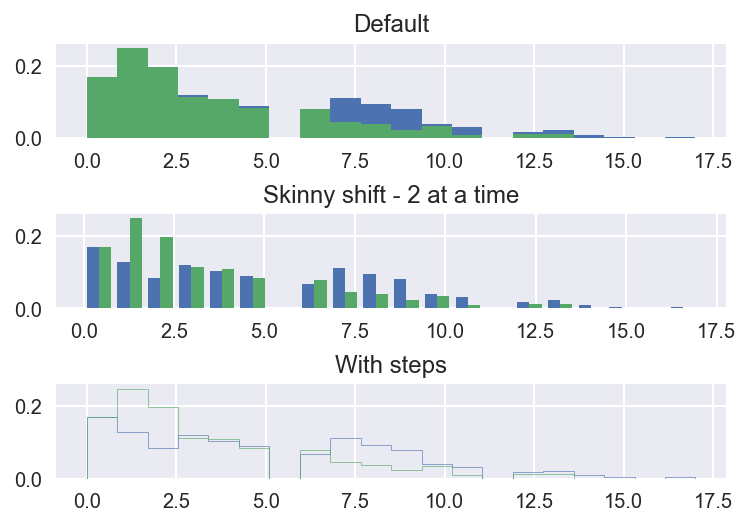

In [30]:
get_hist(df[df.Outcome==1].Pregnancies,df[df.Outcome==0].Pregnancies,values_range=[0,17],
         nbins=20,normed=True,name_image='2hist_Pregnancies.png');

         count        mean        std   min    25%    50%    75%    max
Outcome                                                                
0        488.0  110.825820  24.835897  44.0   93.0  107.5  125.0  197.0
1        264.0  142.488636  29.644020  78.0  119.0  140.5  167.0  199.0


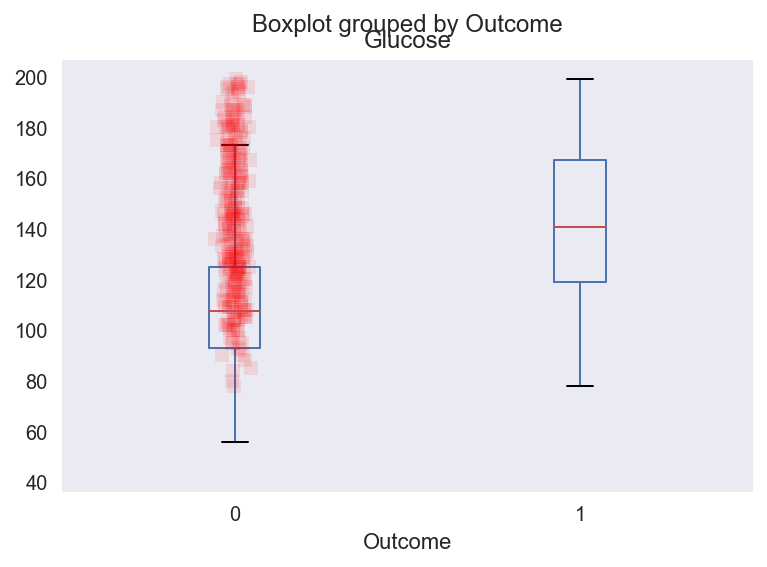

In [31]:
bivariant_boxplot(df=df,column_name='Glucose',target='Outcome')

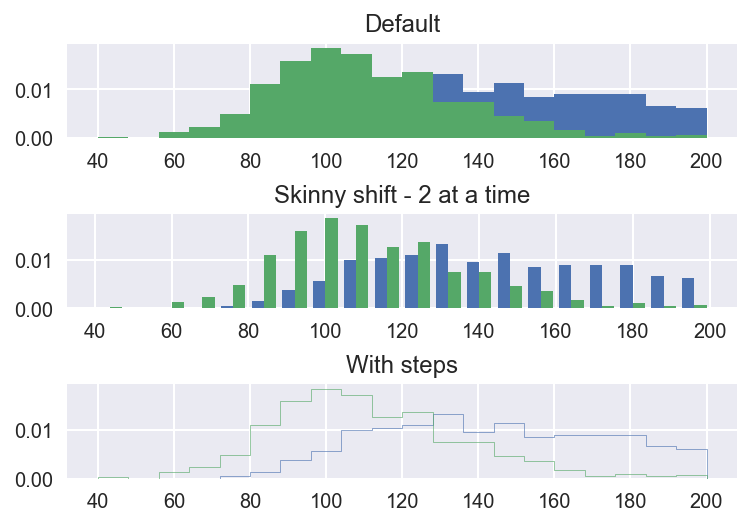

In [32]:
get_hist(df[df.Outcome==1].Glucose,df[df.Outcome==0].Glucose,
         values_range=[40,200],nbins=20,normed=True,name_image='2hist_Glucose.png');

         count       mean       std   min     25%    50%     75%   max
Outcome                                                               
0        488.0  30.876434  6.573208  18.2  25.600  30.10  35.325  57.3
1        264.0  35.371970  6.627329  22.9  30.875  34.25  38.550  67.1


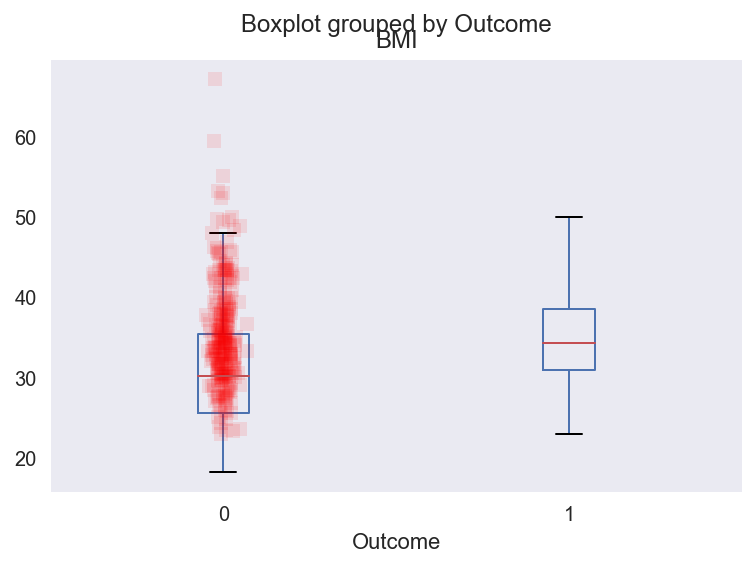

In [33]:
bivariant_boxplot(df=df,column_name='BMI',target='Outcome')

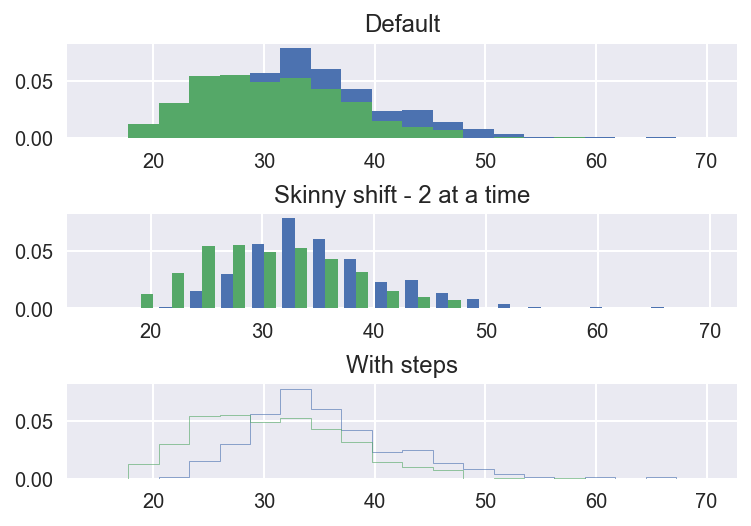

In [34]:
get_hist(df[df.Outcome==1].BMI,df[df.Outcome==0].BMI,
         values_range=[15,70],nbins=20,normed=True,name_image='2hist_BMI.png');

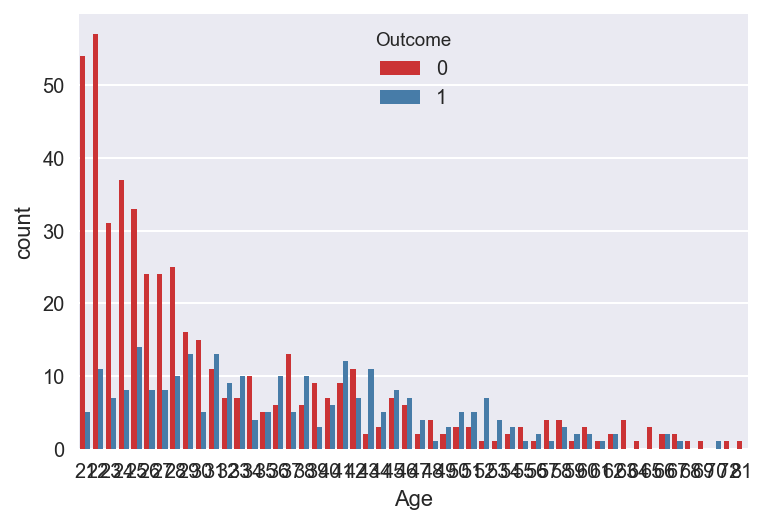

In [35]:
sns.countplot(x='Age', hue='Outcome', data=df, palette='Set1');

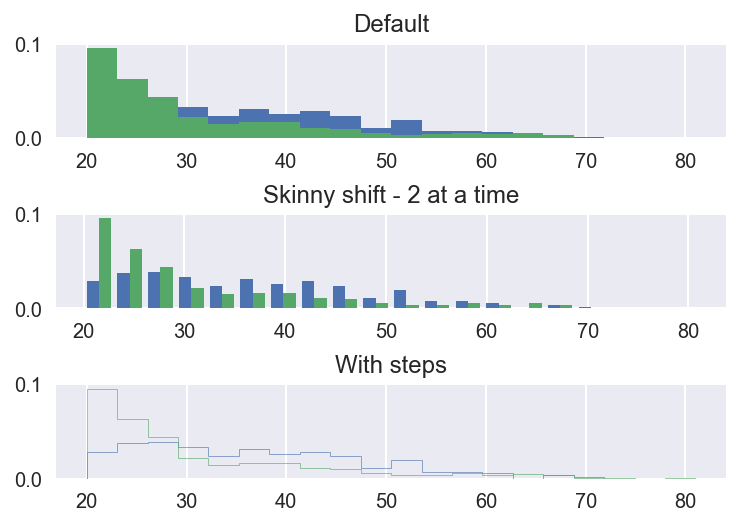

In [36]:
get_hist(df[df.Outcome==1].Age,df[df.Outcome==0].Age,
         values_range=[20,81],nbins=20,normed=True,name_image='2hist_Age.png');

### Transformación de variables

* Se realiza la transformación de variables utilizando MinMaxScaler, el cual escogemos por lo robusto en datos con pequeñas desviaciones estandar y la capacidad de mantener los valores 0


* Referencias: 

    *<http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html>*

    *<http://scikit-learn.org/stable/modules/preprocessing.html>*

In [37]:
df.loc[:,'DiabetesPedigreeFunction']=MinMaxScaler().fit_transform(df[['DiabetesPedigreeFunction']])
df.loc[:,'Age']=MinMaxScaler().fit_transform(df[['Age']])
df.loc[:,'Glucose']=MinMaxScaler().fit_transform(df[['Glucose']])
df.loc[:,'BMI']=MinMaxScaler().fit_transform(df[['BMI']])
df.loc[:,'Pregnancies']=MinMaxScaler().fit_transform(df[['Pregnancies']])
X=df.loc[:, df.columns != 'Outcome']
columns = X.columns
Y=df.Outcome.values.ravel()

### Análisis de correlaciones y kde (densidad de kernel)

* Como podemos ver, las variables si presentan diferencias en su distribución según si son pacientes con o sin diabetes, lo cual es un indicio de que son características que nos permitirán discriminar entre los pacientes con mayor o menor propensión a  padecer la enfermedad


* Salvo en el caso de la edad con el número de embarazos, las variables que hemos dejado como variables explicativas no presentan correlaciones significativas. Decidimos dejar ambas variables correlacionadas, ya que desde el punto de vista de la salud creemos que aportan información distinta, ya que la edad es una característica intrínsica de la persona y el número de embarazos nos muestra una característica dependiente de un comportamiento de la misma, por lo tanto puede aportar información a través de la detección de un patrón en base a ese comportamiento en particular o bien de forma conjunta con el resto de las variables

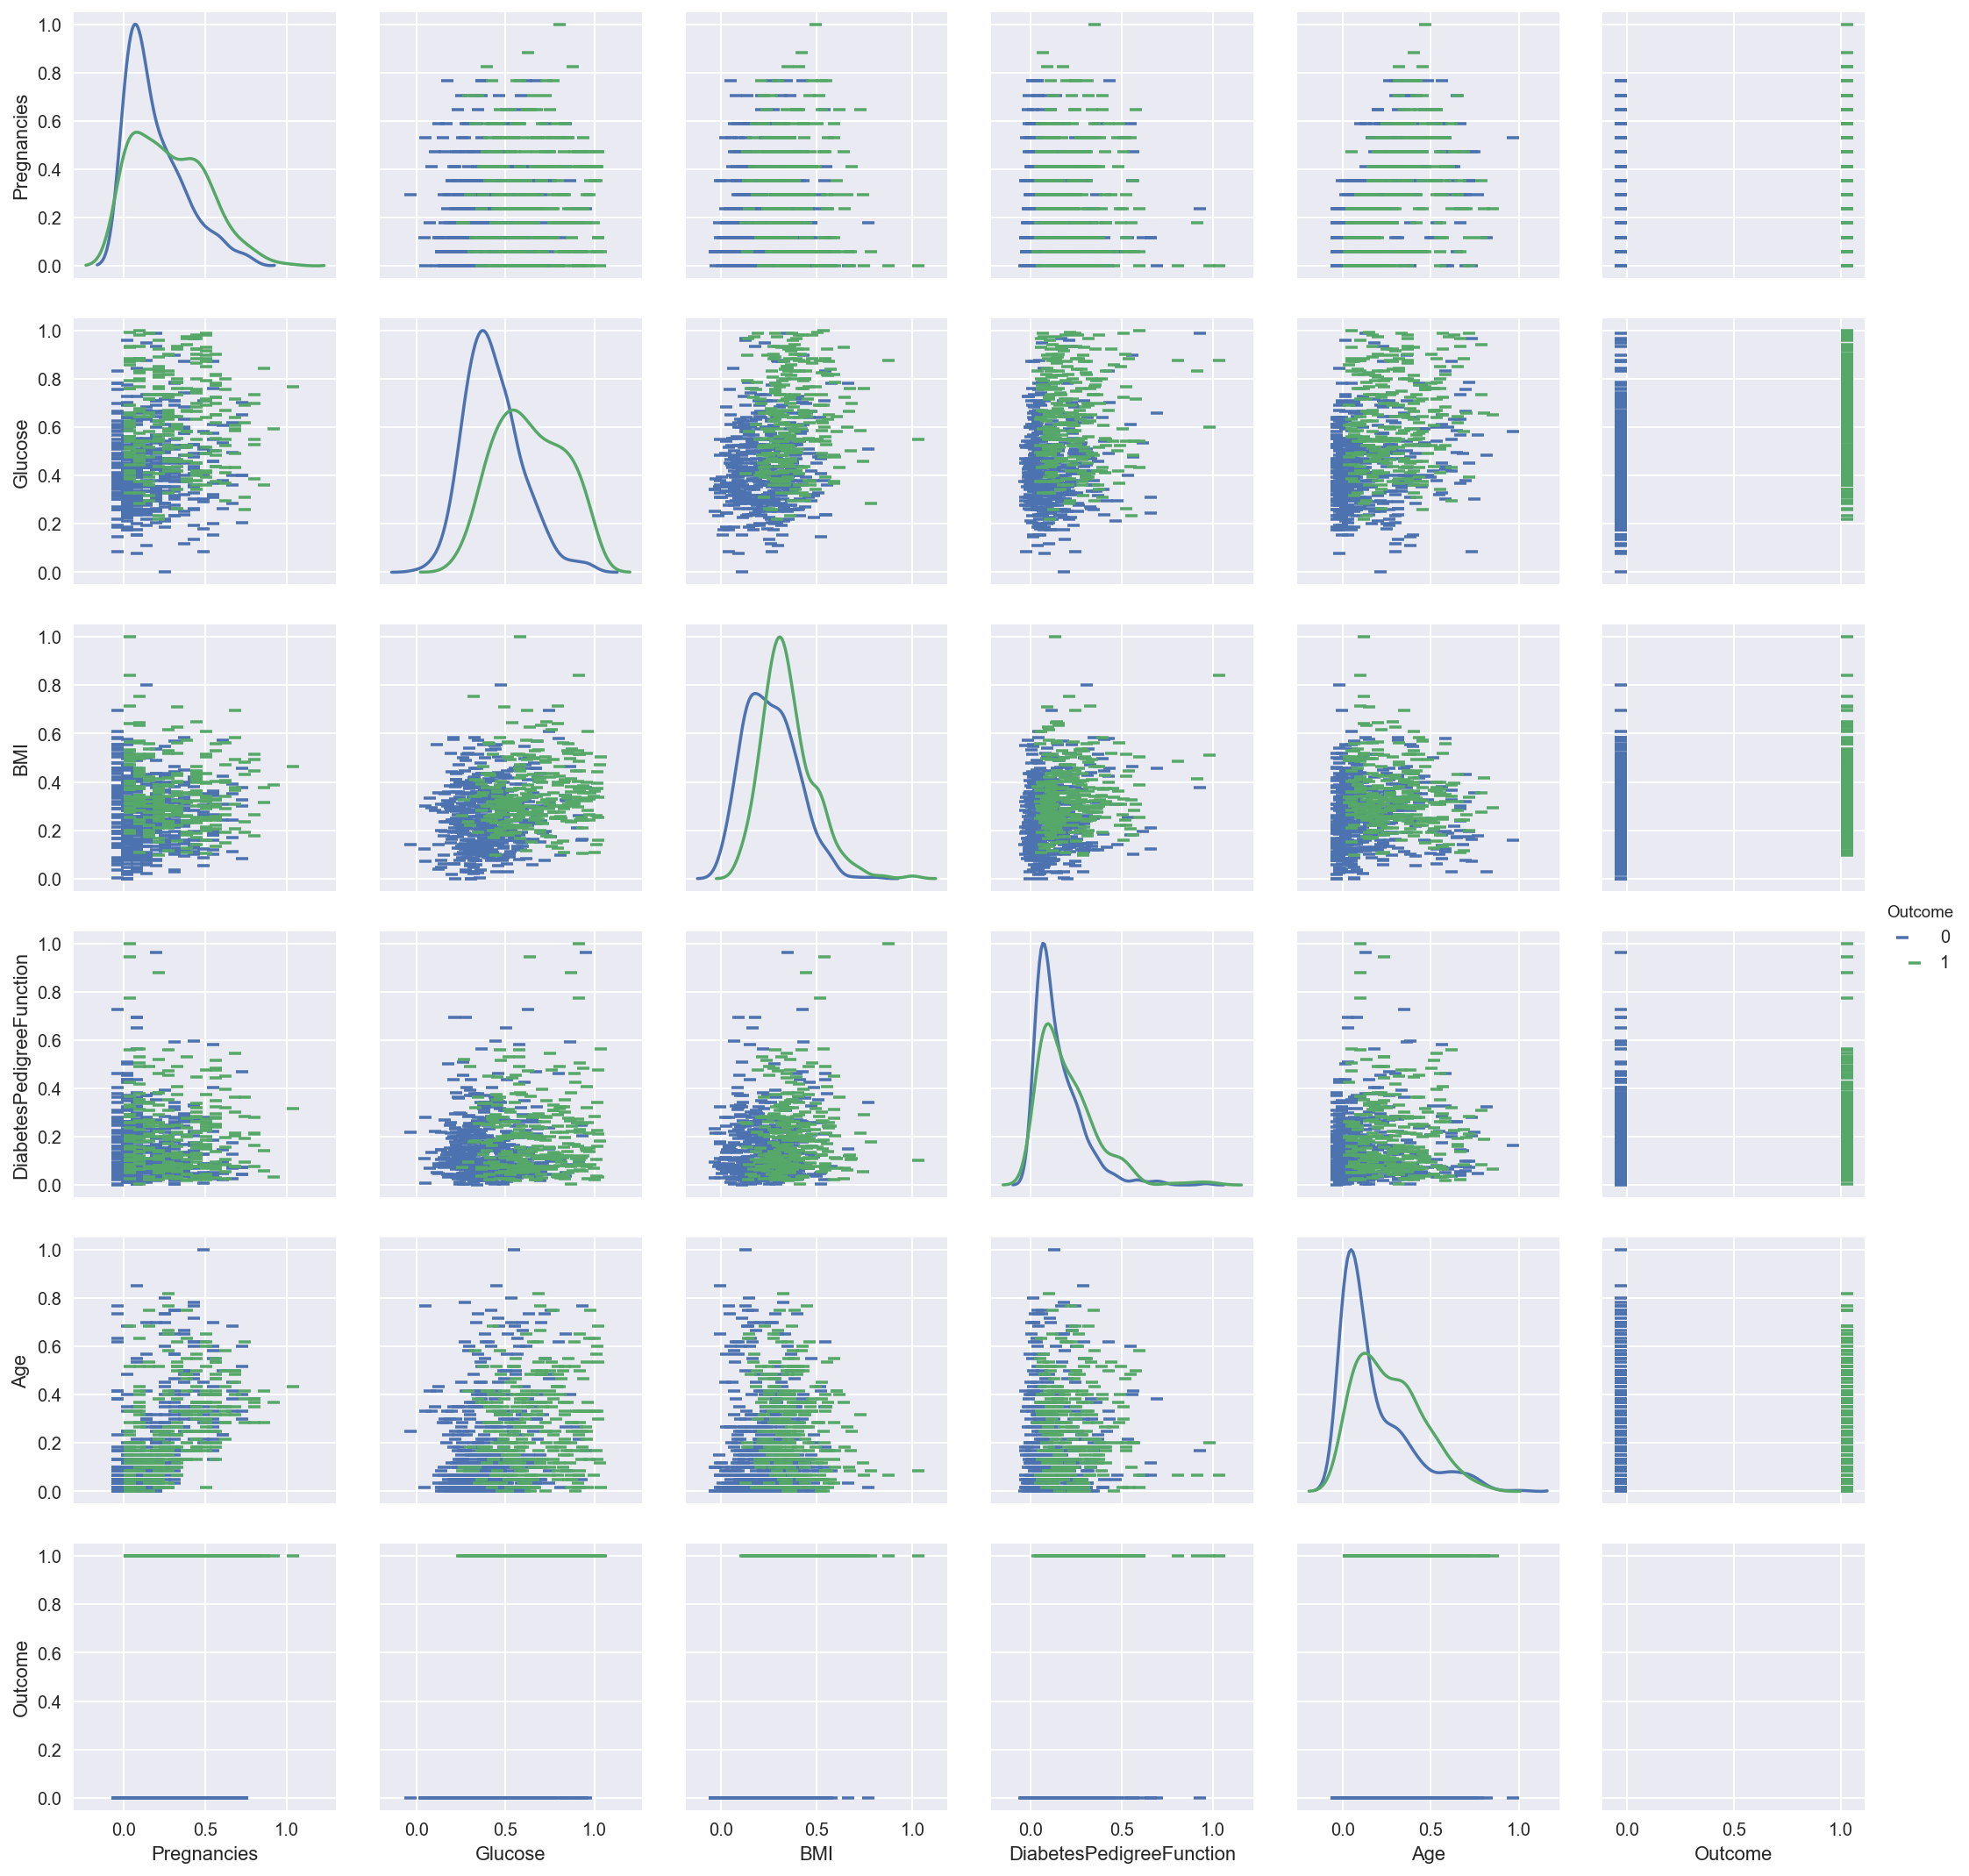

In [38]:
sns.pairplot(data=df,hue='Outcome',diag_kind='kde',markers=[0, 1])
plt.show()

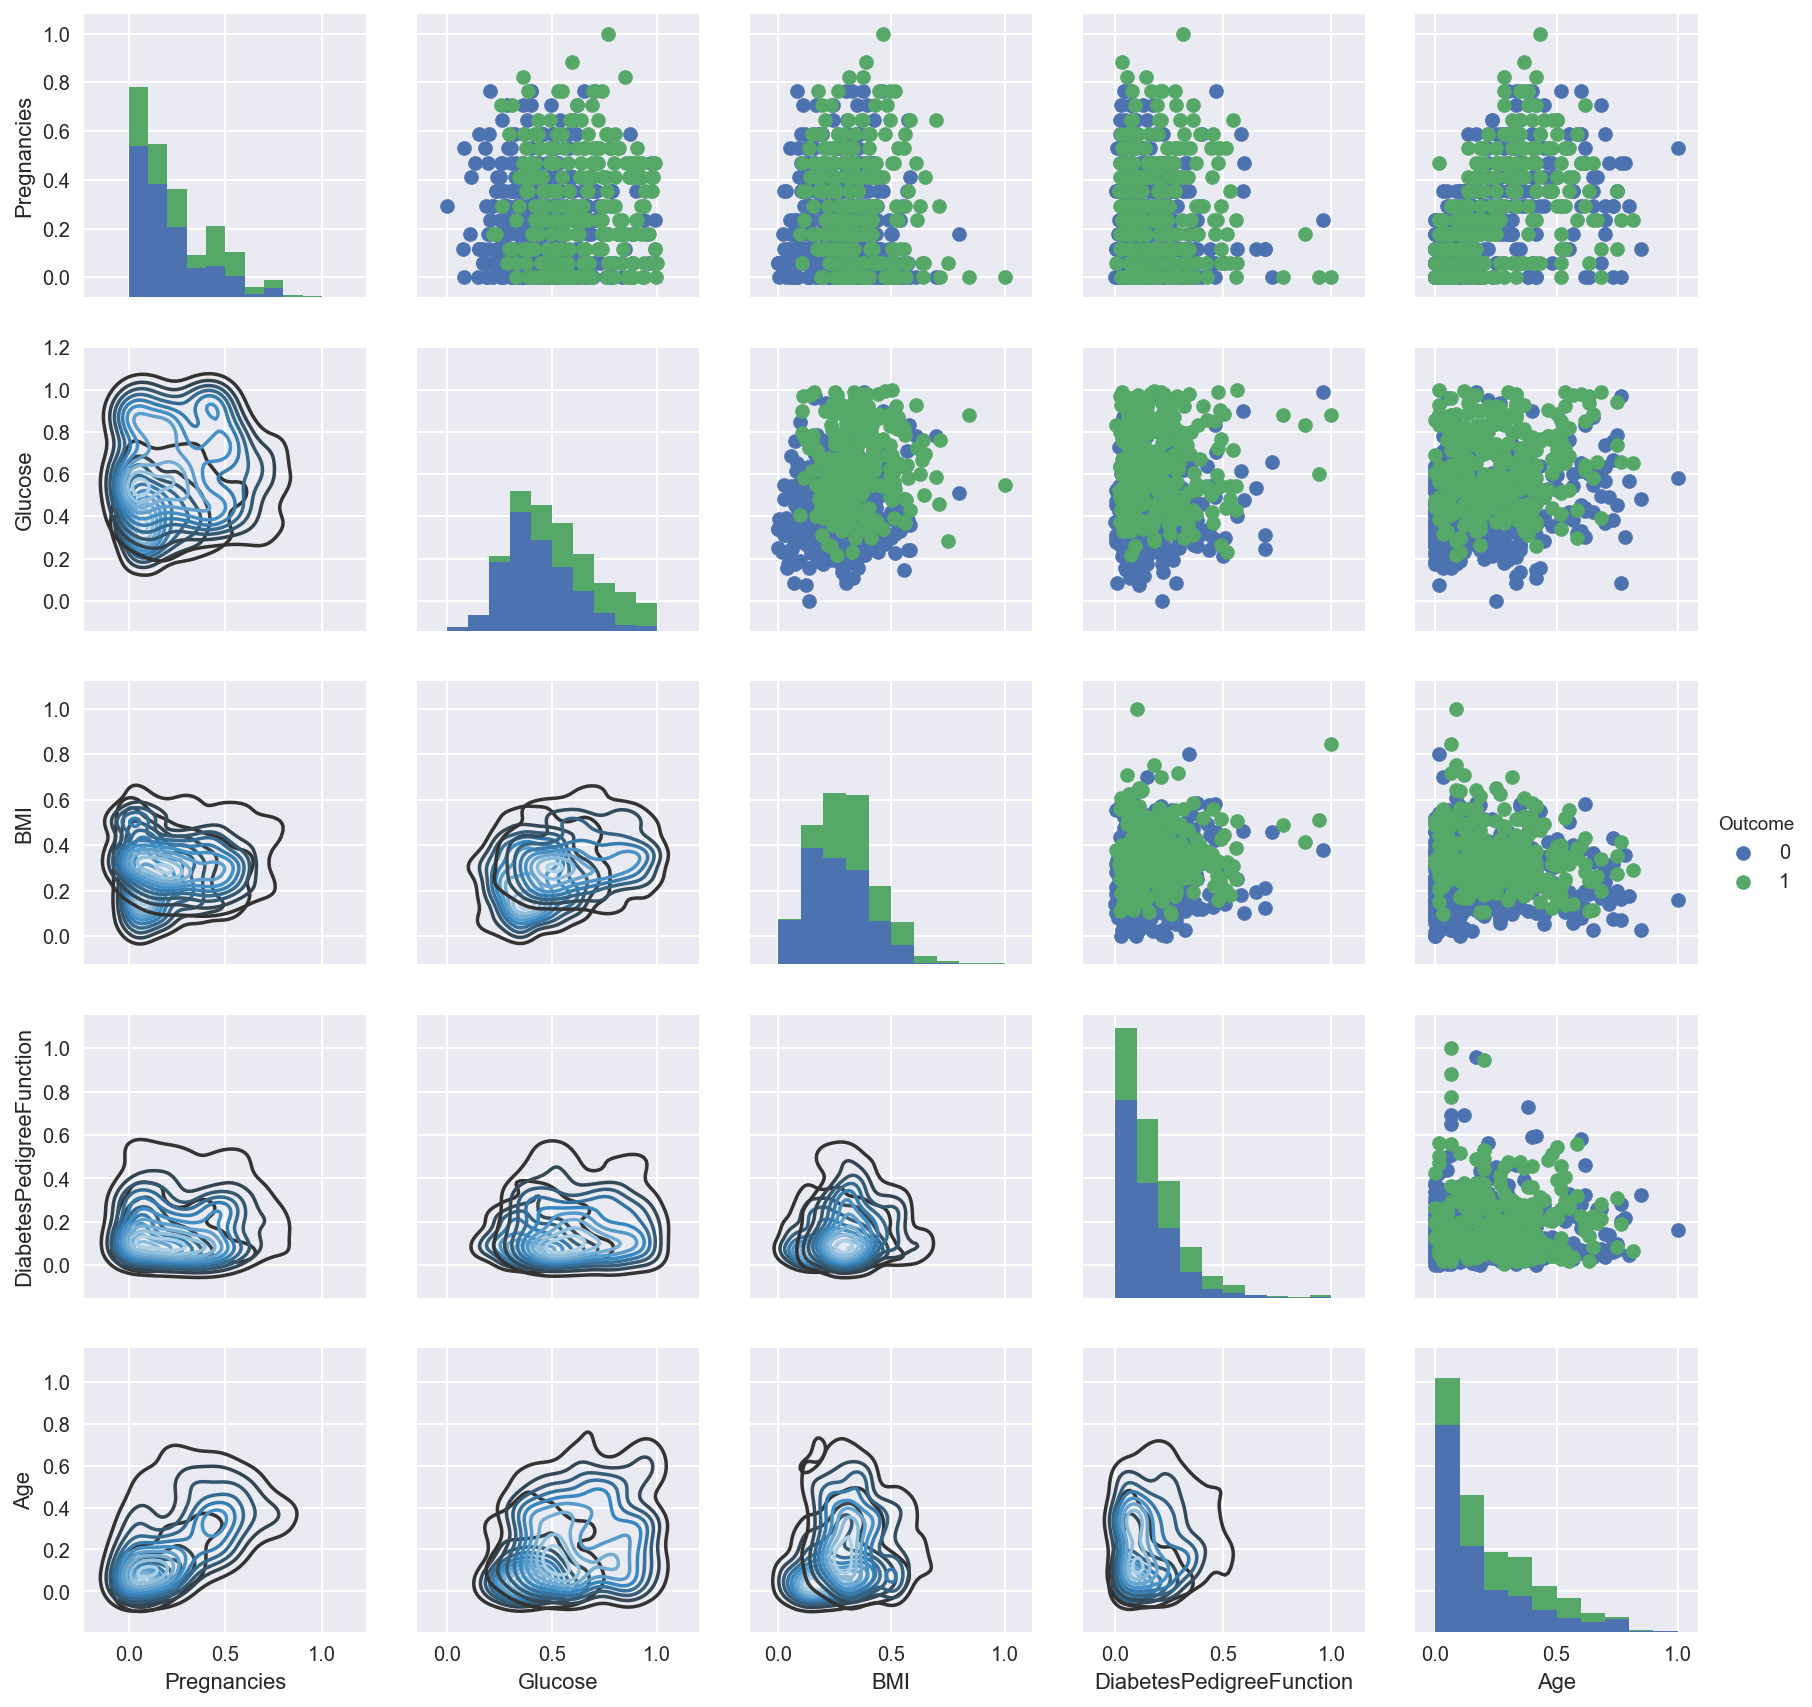

In [39]:
g = sns.PairGrid(df, vars=columns, hue="Outcome", size=2.4)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.add_legend()
plt.show()

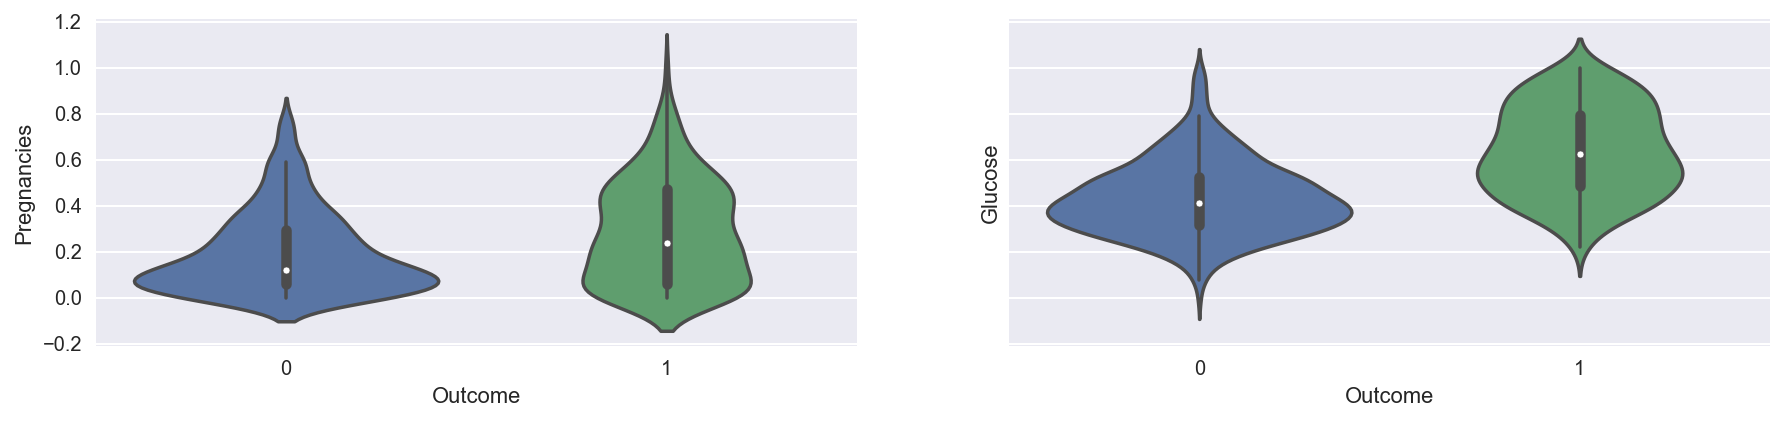

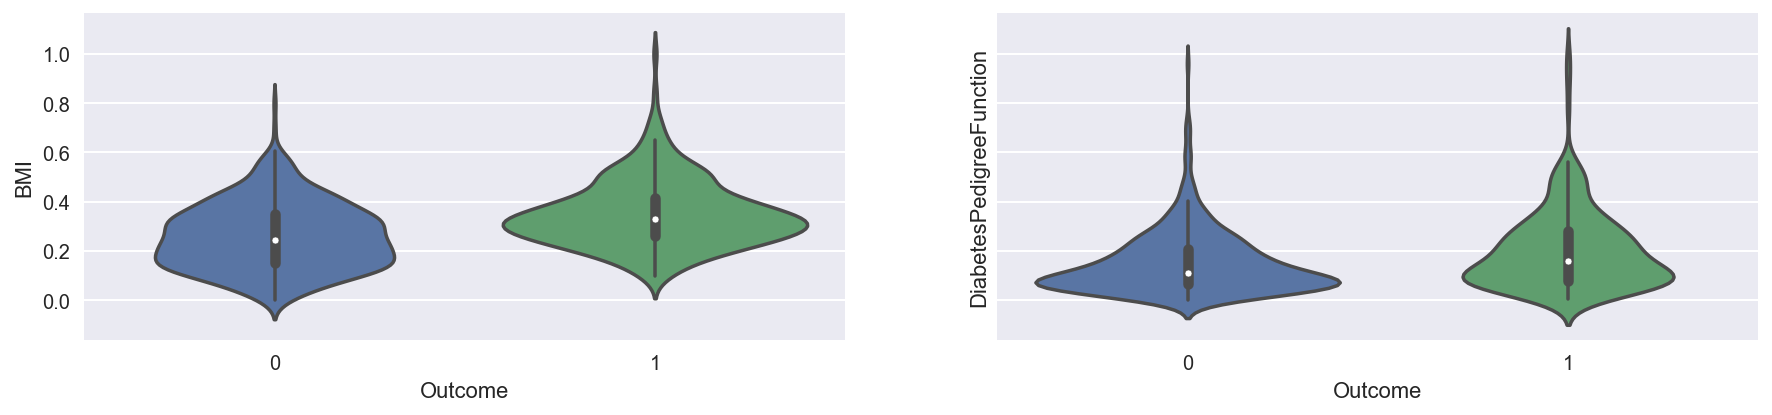

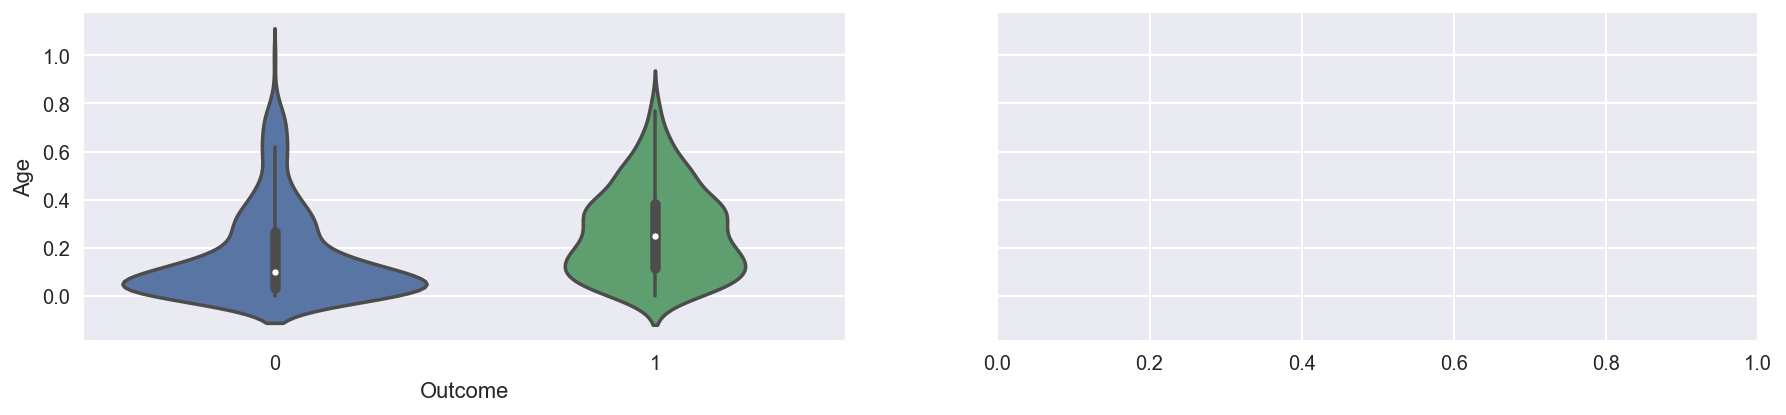

In [40]:
n_cols = 2
n_rows = 3
idx = 0

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(15, 3))
    for j in range(n_cols):
        sns.violinplot(x = df.Outcome, y=df[columns[idx]], ax=ax[j]) 
        idx += 1
        if idx >= 4:
            break

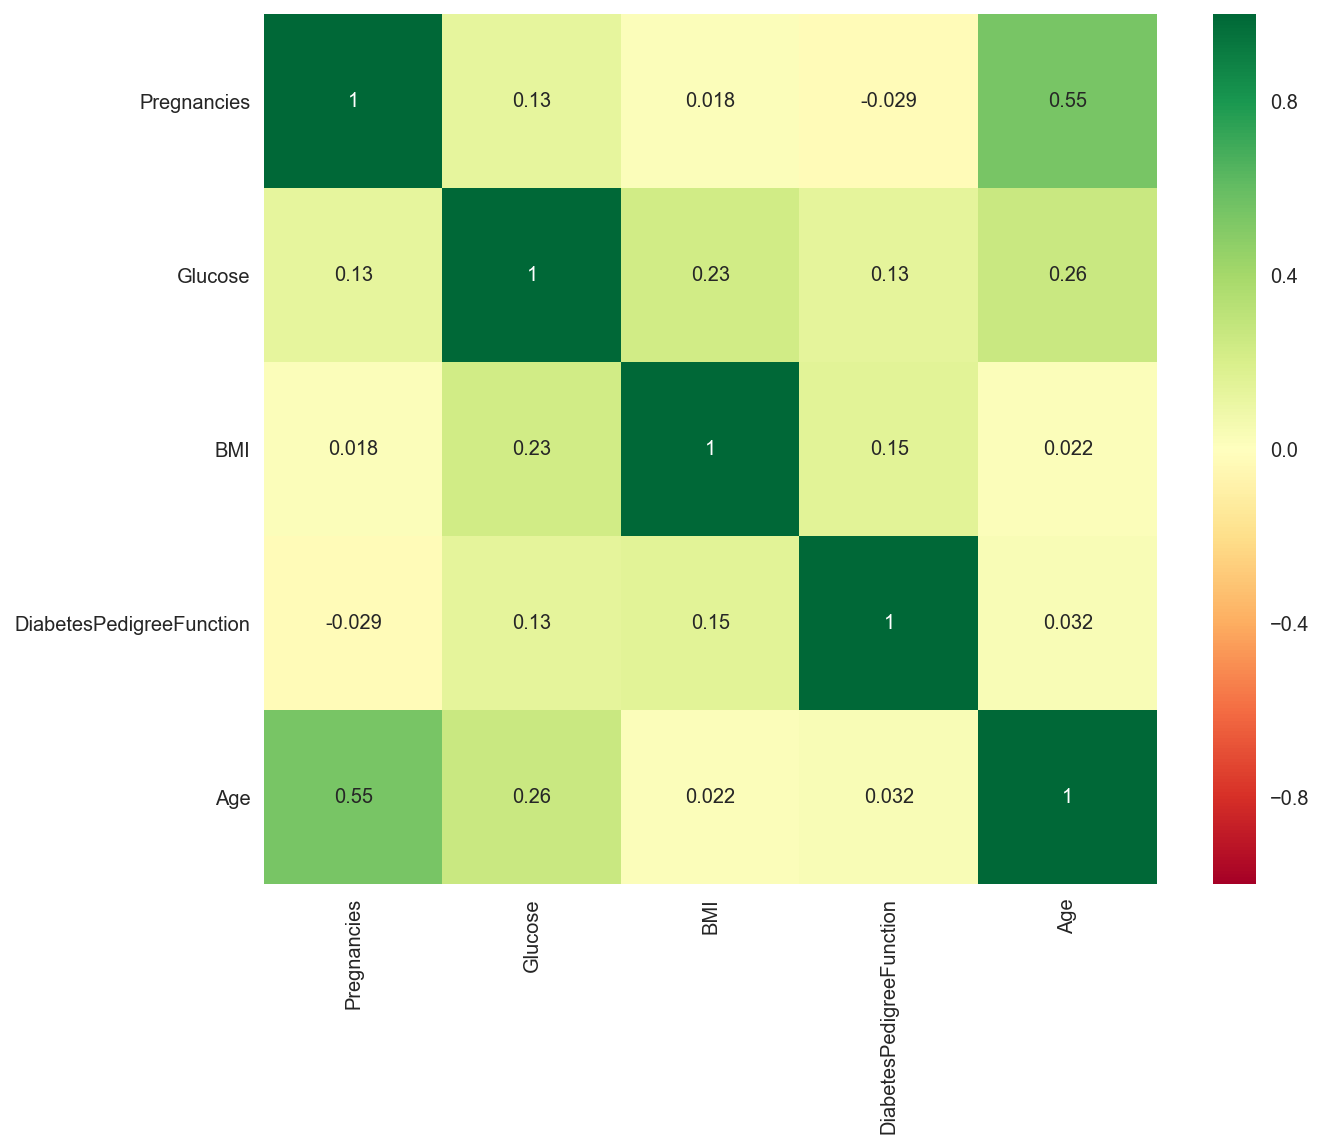

In [41]:
sns.heatmap(df[columns].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### Importancia de las variables

* Podemos ver la importancia esperada de las variables al momento de modelar, en donde aparece el resultado del test de Glucosa y la presión sistólica en la sangre como las dos características más relevantes al momento de determinar la presencia de riesgo de diabetes en un paciente

In [42]:
selected_features=variable_selection(X=X,y=Y)
selected_features

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
0,Glucose,0.131128,1.000000,1,1,3,2.058540,1
1,BMI,0.090087,0.687019,2,2,2,1.459198,2
2,Age,0.065700,0.501038,3,5,4,0.211629,5
3,Pregnancies,0.037008,0.282231,5,3,5,0.694483,3
4,DiabetesPedigreeFunction,0.006552,0.049968,4,4,1,0.670233,4


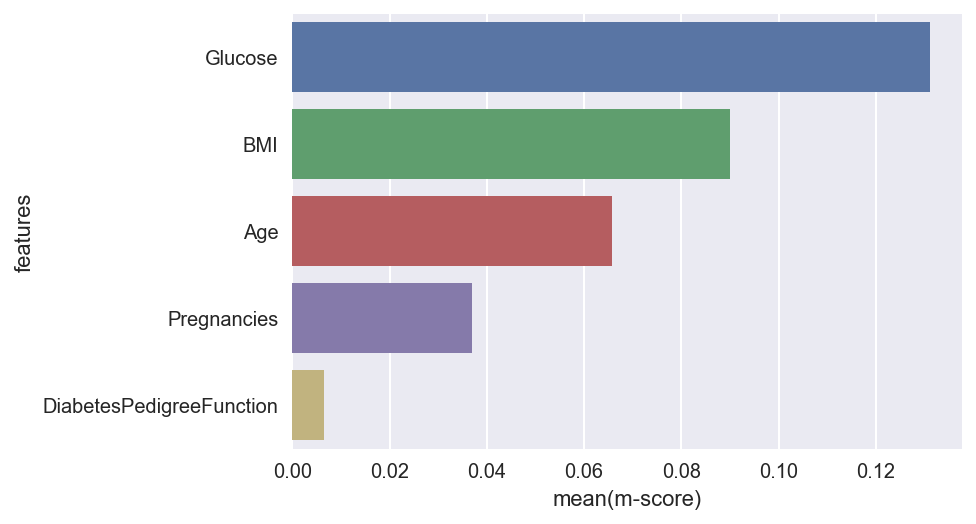

In [43]:
sns.barplot(x='m-score', y='features', data=selected_features);